In [1]:
import random

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal
import scipy.stats
import sympy
import seaborn as sns
import pandas as pd
import numba
from scipy.stats import entropy
#plt.warnings.filterwarnings('ignore', "The 'normed' kwarg is deprecated")

red, blue, green = sns.color_palette('Set1', 3)

First, define the simulator.  
N = population size  
s_cnv = fitness benefit of CNVs  
s_snv = fitness benefit of SNVs  
m_cnv = probability mutation to CNV  
m_snv = probability mutation to SNV

*Note - I should probably edit to have it save/return only the 25 timepoints we'll use for memory purposes* 

In [2]:
c

Define a delfi simulator class linking to the simulator:

*note: could build this to have a burn in period to simulate standing variation*

In [3]:
from delfi.simulator.BaseSimulator import BaseSimulator

class CNVevo(BaseSimulator):
    def __init__(self, N, s_snv, m_snv, generation, seed=None):
        """ CNV evolution simulator
        Simulates CNV and SNV evolution for 267 generations
        Returns proportion of the population with a CNV per generation as 1d np.array of length 267
    
        Parameters
        -------------------
        N : int
            population size  
        s_snv : float
            fitness benefit of SNVs  
        m_snv : float 
            probability mutation to SNV
        gen : np.array, 1d 
            with generations 0 through the end of simulation
        seed : int or None
            If set, randomness across runs is disabled
        """
        dim_param = 2

        super().__init__(dim_param=dim_param, seed=seed)
        self.N = N
        self.s_snv = s_snv
        self.m_snv = m_snv
        self.generation = generation
        self.CNVsimulator = CNVsimulator

    def gen_single(self, cnv_params):
        """Forward model for simulator for single parameter set

        Parameters
        ----------
        params : list or np.array, 1d of length dim_param
            Parameter vector

        Returns
        -------
        dict : dictionary with data
            The dictionary must contain a key data that contains the results of
            the forward run. Additional entries can be present.
        """
        params = np.asarray(cnv_params)

        assert params.ndim == 1, 'params.ndim must be 1'

        sim_seed = self.gen_newseed()
        states = self.CNVsimulator(N, s_snv, m_snv, cnv_params, generation, seed=sim_seed)
        
        return {'data': states.reshape(-1),
                'generation': self.generation,
                's_snv': self.s_snv,
                'm_snv': self.m_snv,
                'N': self.N}

Prior over model parameters. Model parameters are CNV fitness effects and CNV mutation rates. Will use a uniform distribution.

In [4]:
import delfi.distribution as dd

seed_p = 2
prior_min = np.log10(np.array([1e-3,1e-12]))
prior_max = np.log10(np.array([0.3,1e-4]))
prior = dd.Uniform(lower=prior_min, upper=prior_max,seed=seed_p)

"Summary statistics" here will be the proportion of the population each of the 25 timepoints that were measured in Lauer et al. 2018.

In [5]:
from delfi.summarystats.BaseSummaryStats import BaseSummaryStats
from scipy import stats as spstats

class CNVStats(BaseSummaryStats):
    """Moment based SummaryStats class for the CNV evolution model

    Calculates summary statistics
    """
    def __init__(self, n_summary=25, seed=None):
        """See SummaryStats.py for docstring"""
        super(CNVStats, self).__init__(seed=seed)
        self.n_summary = n_summary

    def calc(self, repetition_list):
        """Calculate summary statistics

        Parameters
        ----------
        repetition_list : list of dictionaries, one per repetition
            data list, returned by `gen` method of Simulator instance

        Returns
        -------
        np.array, 2d with n_reps x n_summary
        """
        exp_gen = np.array([25,33,41,54,62,70,79,87,95,103,116,124,132,145,153,161,174,182,190,211,219,232,244,257,267])
        stats = []
        for r in range(len(repetition_list)):
            #x = repetition_list[r]
            cnv_freq = np.transpose(repetition_list[r]['data'])
            subset = cnv_freq[exp_gen]
            stats.append(subset)

        return np.asarray(stats)

Define a generator class that binds together the simulator classs, the prior over the parameters, and the summary statistics class

Parallelize for speed when using on the HPC

In [6]:
import delfi.generator as dg

# pop size, fitness SNVs, mutation rate SNVs, number of generations
N = 3e8
s_snv=0.002
m_snv=1.67e-10
generation = np.array(range(0,268))

# summary statistics hyperparameters
n_summary = 25


## for local ##
seed_m = 3
m = CNVevo(N, s_snv, m_snv, generation, seed=seed_m)
s = CNVStats(n_summary = n_summary)
g = dg.Default(model=m, prior=prior, summary=s)

## for HPC ##
# threads
#n_processes = 1

#seeds_m = np.arange(1,n_processes+1,1)
#m = []
#s = CNVStats(n_summary = n_summary)
#for i in range(n_processes):
#    m.append(CNVevo(N, s_snv, m_snv, gen, seed=seeds_m[i]))
#g = dg.MPGenerator(models=m, prior=prior, summary=s)

Make some observed data for 9 populations where :
CNV mutation rate: 3.4 x 10-6 gene duplications per gene per generation (Lynch et al. 2008)  
CNV fitness effect: s = .1

Plot that

And calculate the summary statistics for the observed data


**NOTE HERE**
The algorithm as written cannot work with more than one observation at a time  

For now, I am only going to generate one observation and make sure that the entire thing runs on that.

I need to think about how to deal with this.

In [7]:
# true parameters and respective labels
#true_params = np.log10(np.array([.1, 3.4e-6]))
#labels_params = ['CNV fitness effect', 'CNV mutation rate']

# observed data: simulation given true parameters

#### this is the multiple observations version #####
#obs = []
#for i in range(0,25):
#    obs.append(m.gen_single(true_params))
#####################################################

#obs = m.gen_single(true_params)

In [8]:
#fig = plt.figure(figsize=(7,5))
#gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
#ax = plt.subplot(gs[0])
#### this is the multiple observations version #####
#for r in range(len(obs)): 
#    x = obs[r]
#    plt.plot(x['generation'],x['data'])
#####################################################
#x = obs
#plt.plot(x['generation'],x['data'])
#plt.ylabel('CNV frequency')
#plt.xlabel('Generation')
#plt.title('observed data')


In [59]:
#single observation
#obs_stats = s.calc([obs])
obs_stats = np.array(pd.read_csv('PopPropForABC.csv'))[:,8]
# >1 observation
#obs_stats = s.calc(obs)

*Inference with SNPE*   
Hyperparamters (using same as in the delfi tutorial)

In [60]:
seed_inf = 1

pilot_samples = 2000

# training schedule
n_train = 2000
n_rounds = 1

# fitting setup
minibatch = 256
epochs = 100
val_frac = 0.05

# network setup
n_hiddens = [50,50]

# convenience
prior_norm = True

# MAF parameters
density = 'maf'
n_mades = 5

Inference with SNPE-C

In [61]:
import delfi.inference as infer

# inference object
res = infer.APT(g,
                  obs=obs_stats,
                  n_hiddens=n_hiddens,
                  seed=seed_inf,
                  pilot_samples=pilot_samples,
                  n_mades=n_mades,
                  prior_norm=prior_norm,
                  density=density)
# train
log, _, posterior = res.run(
                    n_train=n_train,
                    n_rounds=n_rounds,
                    minibatch=minibatch,
                    epochs=epochs,
                    silent_fail=False,
                    proposal='prior',
                    val_frac=val_frac,
                    verbose=True,)

Plot the loss function

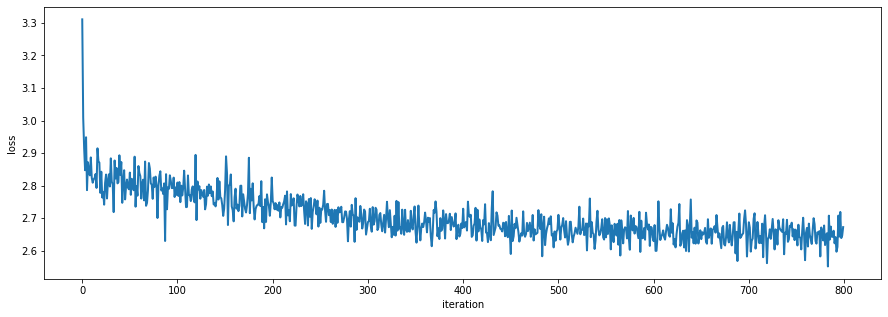

In [62]:
fig = plt.figure(figsize=(15,5))

plt.plot(log[0]['loss'],lw=2)
plt.xlabel('iteration')
plt.ylabel('loss');

Inspect the inferred posterior  
Find Maximum a posteriori estimation (MAP) - which is the mode of the posterior.  
Use kernel density estimate ratio to compare MAP to density at real parameters

All figures together

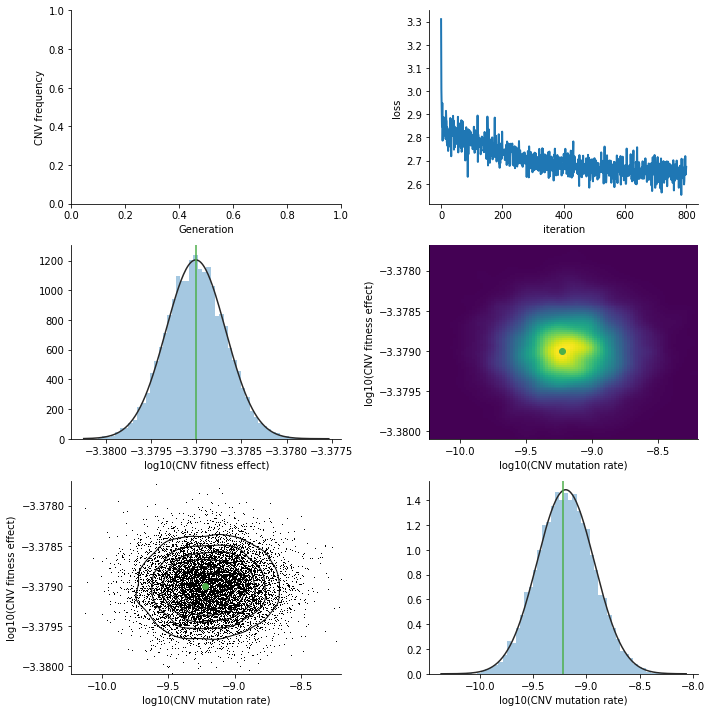

In [63]:
posterior_samples = [posterior[0].gen(10000)]
fitness_samples = posterior_samples[0][:,0]
mut_samples = posterior_samples[0][:,1]
#calculations kde
ymin = fitness_samples.min()
ymax = fitness_samples.max()
xmin = mut_samples.min()
xmax = mut_samples.max()

s_range, μ_range = np.mgrid[ymin:ymax:100j, xmin:xmax:100j]
positions = np.vstack([s_range.ravel(), μ_range.ravel()])
values = np.vstack([fitness_samples, mut_samples])
kernel = scipy.stats.gaussian_kde(values)
density = np.reshape(kernel(positions).T, s_range.shape)

##
#estimates for parameters from the posterior (MAP - highest probability in posterior)
idx = np.argmax(density, axis=None)
s_est = positions[0,idx]
μ_est = positions[1,idx]


fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# observed
#axes[0,0].plot(obs['generation'],obs['data'])
axes[0,0].set(ylabel='CNV frequency', xlabel='Generation')
#axes[0,0].set_title('observed data\nfitness: ' + str(true_params[0]) + '\nmutation: ' + str(true_params[1]))

axes[0,1].plot(log[0]['loss'],lw=2)
axes[0,1].set(xlabel='iteration', ylabel='loss')

# marginal
sns.distplot(fitness_samples, bins=50, fit=scipy.stats.norm, kde=False, ax=axes[1,0]) #change the fit
sns.distplot(mut_samples, bins=50, fit=scipy.stats.norm, kde=False, ax=axes[2,1]) # change the fit

#axes[1,0].axvline(true_params[0], color=red)
axes[1,0].axvline(s_est, color=green)
#axes[2,1].axvline(true_params[1], color=red)
axes[2,1].axvline(μ_est, color=green)


# joint
axes[1,1].pcolormesh(μ_range, s_range, density)
#axes[1,1].plot(true_params[1], true_params[0], color=red, marker='o')
axes[1,1].plot(μ_est, s_est, color=green, marker='o')

axes[2,0].plot(mut_samples, fitness_samples, ',k')
#axes[2,0].plot(true_params[1], true_params[0], color=red, marker='o')
axes[2,0].plot(μ_est, s_est, color=green, marker='o')
axes[2,0].contour(μ_range, s_range, density, colors='k', linewidths=1)

axes[1,0].set(xlabel='log10(CNV fitness effect)')
axes[1,1].set(xlabel='log10(CNV mutation rate)', ylabel='log10(CNV fitness effect)')
axes[2,0].set(xlabel='log10(CNV mutation rate)', ylabel='log10(CNV fitness effect)')
axes[2,1].set(xlabel='log10(CNV mutation rate)')


fig.tight_layout()
plt.title('')
sns.despine()
outfile = 'delfi_REAL8'
plt.savefig(outfile + '.pdf')  

Write out the estimated parameters and "true" parameters

In [64]:
def format(value):
    return "%.12f" % value

f= open("realdata_params.csv","a+")
f.write(','.join(str(format(j)) for j in (s_est,μ_est)) + '\n')
f.close() 

In [65]:
np.array(pd.read_csv('PopPropForABC.csv')).shape

(25, 9)